In [7]:
# n - number of data points
# d - dimensionality
# alpha - number of corrupted points, change the fraction within expression
# mu, sigma - parameters for any gaussian being used, feel free to change
import numpy as np
import matplotlib.pyplot as plt
from irls_lib_cv import *
import statsmodels.api as sm
import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [8]:
from sklearn.base import BaseEstimator
import statsmodels.api as sm

class SVAM(BaseEstimator):
	# w_star is used only to plot convergence curves and not tune the method or decide stopping criterion in any way
	def __init__( self, eta = 1.01, alpha = 0.0, beta_init = 10.0, w_init = None, w_star = None ):
		self.eta = eta
		self.alpha = alpha
		self.beta_init = beta_init
		self.w_init = w_init
		self.w_star = w_star
	
	
	def fit( self, X, y, max_iter = 40, max_iter_w = 1 ):
		start_time=time.time()
		n, d = X.shape
		beta = self.beta_init
		self.w = self.w_init
		self.l2=[]
		self.clock=[]
		itr=0
		
		while itr < max_iter:        
			iter_w = 0
			while iter_w < max_iter_w:
				s=np.power(beta/2*np.pi,0.5)*np.exp(-beta/2 *np.power(np.dot(X,self.w)-y,2)) 
				mod_wls = sm.WLS( y, X, weights = s )
				res_wls = mod_wls.fit()
				self.w = res_wls.params.reshape( d, 1 )
				iter_w += 1     
				self.l2.append( np.linalg.norm( self.w - self.w_star ) )
				self.clock.append( time.time() - start_time )

				if iter_w >=max_iter_w:
					break
			itr += iter_w
			beta*= self.eta
			
		return self
	
	def predict( self, X ):
		return np.dot( X, self.w )
	
	# Return negative RMSE as score since sklearn assumes that score is something to be maximized
	def score( self, X, y ):
		n_test = X.shape[0]
		n_test_corr = int( self.alpha * n_test )
		res = y - self.predict(X)
		res_corr = HT( res, n_test_corr )
		return -np.linalg.norm( res - res_corr, 2) / np.sqrt( n_test - n_test_corr )    

In [9]:
#cross_validation=False
cross_validation=True

n = 5000
d = 10
alpha  = 0.15

n_corr  = int(alpha*n)

In [13]:
# Data Preparation
Idx= np.random.permutation(n)
corrIdx= Idx[0:n_corr]
cleanIdx=Idx[n_corr:n]

mu = 0
sigma = 1
X = np.random.normal(mu, sigma, (n, d))

w_star= np.random.normal(0,1, (d, 1))
w_star = w_star / np.linalg.norm(w_star)
w_adv= np.random.normal(0,1, (d, 1))

y=np.zeros(shape=(n,1))
y[cleanIdx] = np.dot(X[cleanIdx,:], w_star)
y[corrIdx] = np.dot(X[corrIdx,:], w_adv)

In [11]:
#-----------VAM--------------#
betas=[2, 1, 0.5, 0.1, 0.01]
l2_vam_list=[]
clock_vam_list=[]
for i in range(len(betas)):
    svam = SVAM( eta = 1, alpha = alpha, beta_init = betas[i], w_init = w_adv, w_star = w_star )
    svam.fit( X, y , max_iter=30)
    l2_vam_list.append(svam.l2)
    clock_vam_list.append(svam.clock)

#-----------SVAM--------------#
if cross_validation:
    eta_range = np.linspace( 1.01, 20, 10 )
    beta_init_range = np.power( 10.0, [-2, -1] )
    alpha_range = np.linspace( alpha, alpha, 1 )
    # SVAM does not itself use alpha as a hyperparameter in the algorithm
    # but does need it to perform cross-validation since the validation sets
    # are also corrupted. To avoid an unfair comparison, We offer SVAM a
    # handicap by giving it the true value of alpha
    param_grid = dict( eta = eta_range, beta_init = beta_init_range, alpha = alpha_range )
    cv = ShuffleSplit( n_splits = 5, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( SVAM( w_init = w_adv, w_star = w_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X, y )
    best = grid.best_params_
    print("The best parameters for SVAM are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    svam = SVAM( eta = best["eta"], alpha = best["alpha"], beta_init = best['beta_init'], w_init = w_adv, w_star = w_star )
else:
    svam = SVAM( eta = 10, alpha = alpha, beta_init = 0.01, w_init = w_adv, w_star = w_star )
    
svam.fit( X, y )

The best parameters for SVAM are {'alpha': np.float64(0.15), 'beta_init': np.float64(0.1), 'eta': np.float64(3.12)} with a score of -0.00


,eta,np.float64(3.12)
,alpha,np.float64(0.15)
,beta_init,np.float64(0.1)
,w_init,array([[-0.37...-0.28468251]])
,w_star,array([[-0.02... 0.28815515]])


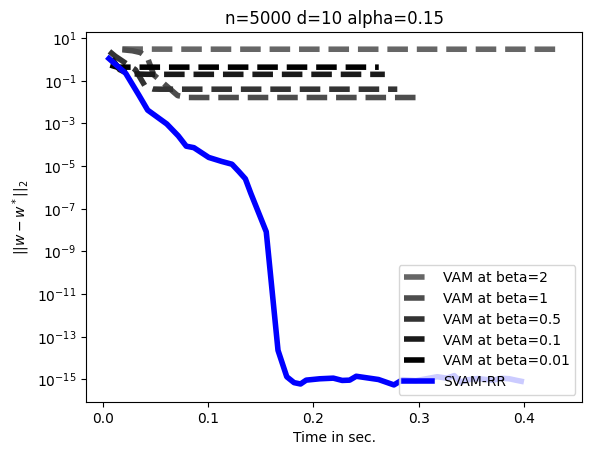

In [12]:
import matplotlib.pyplot as plt

colors=np.arange(len(betas))*0.1
for i in range(len(betas)):    
    plt.plot(clock_vam_list[i], l2_vam_list[i], label = 'VAM at beta={}'.format(str(betas[i])), color=str(colors[-i-1]), linewidth=4,ls='--') #, marker='+', markersize='10',

plt.plot(svam.clock, svam.l2, label = 'SVAM-RR', color='blue',linewidth=4) #ls='--', marker='o', markersize='10'
plt.yscale('log')
plt.legend(loc='lower right') #,prop = {'size': 10}, framealpha=0.25
plt.xlabel('Time in sec.')
plt.ylabel(r'$||w-w^*||_2$')
plt.title('n='+str(n)+' d='+str(d)+' alpha='+str(alpha))
#plt.savefig('vam_vs_svam.pdf')
plt.show()